In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

## Methods for the Package

In [97]:
channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '/Users/antonialutz/code/ThorstenCodes/MorphoMind/raw_data/plate_24277'
platenr = '24277'

def getting_image_paths(base_dir, channel):
    # Correctly construct the channel directory path
    channel_dir = os.path.join(base_dir, f'{channel}/24277-{channel}')
    image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    return image_files


In [90]:
def stitch_images_to_grid(image_paths, grid_shape=(3, 2)):
    # Assuming all images have the same dimensions
    sample_img = Image.open(image_paths[0])
    img_width, img_height = sample_img.size
    
    # Determine the grid's total size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]
    
    # Create an empty array for the grid
    grid_array = np.zeros((grid_height, grid_width), dtype=np.uint16)
    
    # Load and place each image into the grid array
    for index, img_path in enumerate(image_paths):
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        # Load the image and convert to numpy array
        img = Image.open(img_path)
        img_array = np.array(img)
        # Place the image in the correct position
        grid_array[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = img_array
    
    return grid_array

In [91]:


# Function to parse well information from filename
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

# Assuming 'image_files' contains all image paths

def compose_image(image_files):
    well_to_images = {}
    for image_path in image_files:
        well = parse_well_from_filename(os.path.basename(image_path))
        if well not in well_to_images:
            well_to_images[well] = []
        well_to_images[well].append(image_path)
    # Combine images for each well into a composite image
    composite_images = {well: stitch_images_to_grid(paths) for well, paths in well_to_images.items()}
    return composite_images



In [92]:
def composite_images_per_channel(base_dir, channel):
    img_files = getting_image_paths(base_dir, channel)
    composed_imgs = compose_image(img_files)
    return composed_imgs

In [93]:
def display_image_per_well(base_dir, channel, well):
    img_files = getting_image_paths(base_dir, channel)
    composed_imgs = compose_image(img_files)
    well_img = composed_imgs[well]
    plt.figure(figsize=(10, 8))
    plt.imshow(well_img)
    return well_img

## Running the stitching per Channel over all Wells per Channel

In [45]:
composite_images_per_channel('Hoechst')

{'c22': array([[161, 157, 158, ..., 621, 608, 568],
        [153, 152, 151, ..., 690, 718, 708],
        [151, 155, 151, ..., 826, 867, 860],
        ...,
        [164, 159, 164, ..., 179, 177, 174],
        [163, 163, 174, ..., 177, 166, 173],
        [159, 175, 162, ..., 179, 178, 175]], dtype=uint16),
 'f20': array([[167, 165, 144, ..., 143, 144, 140],
        [150, 150, 152, ..., 138, 138, 143],
        [149, 145, 146, ..., 153, 137, 145],
        ...,
        [137, 140, 130, ..., 173, 171, 170],
        [140, 131, 130, ..., 168, 160, 165],
        [135, 135, 137, ..., 174, 166, 164]], dtype=uint16),
 'g09': array([[175, 162, 163, ..., 504, 419, 403],
        [175, 170, 166, ..., 543, 458, 383],
        [164, 165, 163, ..., 544, 499, 397],
        ...,
        [158, 152, 158, ..., 152, 152, 150],
        [155, 156, 152, ..., 147, 149, 145],
        [149, 154, 149, ..., 145, 155, 145]], dtype=uint16),
 'p13': array([[132, 133, 135, ..., 133, 131, 141],
        [139, 133, 131, ..., 1

## Run stitching per Channel and Well here

array([[226, 250, 324, ..., 147, 153, 151],
       [224, 248, 308, ..., 158, 151, 155],
       [238, 236, 288, ..., 147, 150, 155],
       ...,
       [153, 144, 144, ..., 157, 157, 154],
       [149, 155, 140, ..., 152, 155, 143],
       [154, 146, 151, ..., 164, 149, 157]], dtype=uint16)

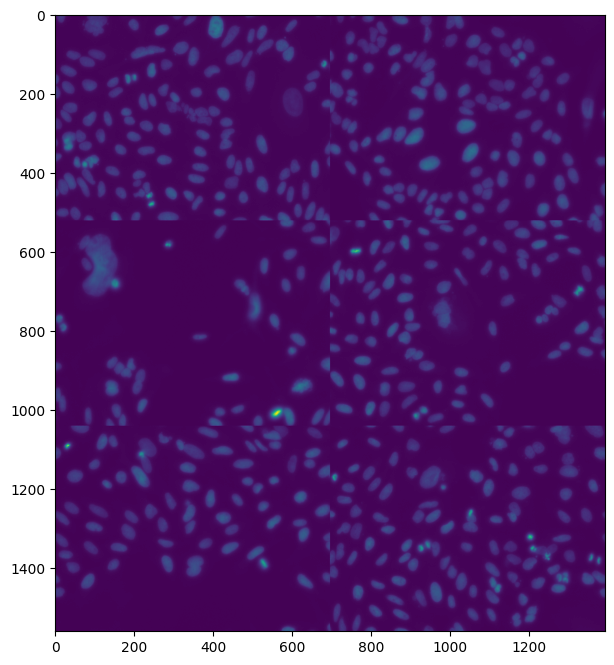

In [48]:
display_image_per_well('Hoechst','a01')

## Run Method to store all stitched images in new directory processed_images

In [99]:
parent_dir = os.path.abspath(os.path.join(base_dir,'..', '..'))
processed_images_dir = os.path.join(parent_dir, 'processed_images')
plate_dir = os.path.join(processed_images_dir, f'plate_{platenr}')

os.makedirs(processed_images_dir, exist_ok=True)
os.makedirs(plate_dir, exist_ok=True)

for channel in channels:
    #channel_dir = os.path.join(base_dir, f'{channel}')
    processed_channel_dir = os.path.join(plate_dir, channel)
    
    os.makedirs(processed_channel_dir, exist_ok=True)
    
    composed_imgs = composite_images_per_channel(base_dir, channel)  # Adjust based on actual function
    
    for well, img in composed_imgs.items():
        stitched_image = Image.fromarray(img) if not isinstance(img, Image.Image) else img
        stitched_image_path = os.path.join(processed_channel_dir, f"{platenr}_{channel}_{well}.tif")
        stitched_image.save(stitched_image_path)
        
        print(f"Saved stitched image for {channel} at {stitched_image_path}")

Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_k15.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_c03.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_i22.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_g14.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_o10.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_d24.tif
Saved stitched image for ERSyto at /Users/antonialutz/code/ThorstenCodes/MorphoMind/processed_images/plate_24277/ERSyto/24277_ERSyto_b21.tif
Saved stitche